In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import pydrake
from pydrake.all import (
    PiecewisePolynomial, RigidTransform, RotationMatrix, JacobianWrtVariable
)

from src.drake_helpers import (
    BuildAndSimulateTrajectory, 
    setup_manipulation_station,
    visualize_transform,
    GripperControllerUsingIiwaState,
    GripperControllerUsingIiwaStateV2,
)
from src.ik import (
    create_q_knots, 
    pose_to_jointangles, 
    jointangles_to_pose, 
    spatial_velocity_jacobian_at_jointangles,
)
from src.throw import (
    plan_pickup,
    plan_prethrow_pose,
    add_go_to_ja_via_jointinterpolation,
    add_go_to_pose_via_jointinterpolation,
    plan_throw,
)
from src.trajectory import get_launch_speed_required

# cleaner debugging
np.set_printoptions(precision=3, suppress=True)

In [2]:
# start a single meshcat server instance to use for remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
print(web_url)

http://127.0.0.1:7021/static/


## The next cell determines everything relevant to the throw

In [3]:
'''
setup
'''
# Get initial pose of the gripper by using default context of manip station.
P_WORLD_TARGET = np.array([-7, 7, -1])
GRIPPER_TO_OBJECT_DIST = 0.13 # meters, this is how much "above" the balls origin we must send the gripper body frame in order to successfully grasp the object

T_world_target = RigidTransform(RotationMatrix(), P_WORLD_TARGET)
T_world_objectInitial = RigidTransform(
    p=[-.1, -.69, 1.04998503e-01],
    R=RotationMatrix.MakeZRotation(np.pi/2.0)
)
T_world_gripperObject = RigidTransform(
    p=T_world_objectInitial.translation() + np.array([0, 0, GRIPPER_TO_OBJECT_DIST]),
    R=RotationMatrix.MakeXRotation(-np.pi/2.0)
)
T_world_robotInitial, meshcat = setup_manipulation_station(T_world_objectInitial, zmq_url, T_world_target)

#object frame viz
visualize_transform(meshcat, "T_world_obj0", T_world_objectInitial)
T_world_target = RigidTransform(
    p=P_WORLD_TARGET,
    R=RotationMatrix()
)
visualize_transform(meshcat, "T_world_obj0", T_world_objectInitial)
visualize_transform(meshcat, "target", T_world_target)

'''
throw
* heading (top down view of the xy plane, relative to the positive x axis)
* release angle (relative to azimuth)
* release velocity
'''
print(f"-------Planning throw-------")
throw_heading = np.arctan2(P_WORLD_TARGET[1], P_WORLD_TARGET[0])

# we need these states to calculate the jacobian
ja1 = throw_heading - np.pi
# you can play around with these to achieve different "release" poses
prethrow_ja = np.array([ja1, 0, 0, 2.00, 0, -2.0, 0, 0, 0])
throwend_ja = np.array([ja1, 0, 0, 0.9, 0, -0.9, 0, 0, 0])
release_ja = prethrow_ja + 0.5 * (throwend_ja - prethrow_ja)
T_world_releasePose = jointangles_to_pose(release_ja[:7])
T_world_prethrowPose = jointangles_to_pose(prethrow_ja[:7])
print(f"Release joint angles: {release_ja}")

# calculate jacobian at release 
J_G = spatial_velocity_jacobian_at_jointangles(
    jointangles=release_ja[:7],
    gripper_to_object_dist=GRIPPER_TO_OBJECT_DIST - 0.04 # <==== important, subtract ball radius
)
J_G_joint4 = J_G[3:, 3] # spatial velocity only
J_G_joint6 = J_G[3:, 5] # spatial velocity only
J_G_joints46 = np.zeros((3, 2))
J_G_joints46[:, 0] = J_G_joint4
J_G_joints46[:, 1] = J_G_joint6
print(J_G_joints46)

# calculate angle at release
release_spatial_dir = J_G_joints46 @ (throwend_ja - prethrow_ja)[[3, 5]]
print(f"Release spatial direction: {release_spatial_dir}")
angle_above_plane_rads = np.arctan2(
    release_spatial_dir[2],
    np.linalg.norm(release_spatial_dir[:2])
)
print(f"Throw angle (above xy plane) degs: {angle_above_plane_rads * 180.0 / np.pi}")

# calculate required release velocity magnitude
p_release = (
    T_world_releasePose.translation()
  + T_world_releasePose.rotation().multiply([0, GRIPPER_TO_OBJECT_DIST, 0])
)
delta_x = np.linalg.norm(P_WORLD_TARGET[:2]) - np.linalg.norm(p_release[:2]) # dist on xy plane
delta_y = P_WORLD_TARGET[2] - p_release[2] # height difference
mag_v0_reqd = get_launch_speed_required(theta=angle_above_plane_rads, x=delta_x, y=delta_y)
mag_v0_reqd = mag_v0_reqd
print(f"Initial velocity magnitude: {mag_v0_reqd}")

# calculate required time for throw motion
time_reqd = np.linalg.norm(release_spatial_dir) / mag_v0_reqd
print(f"time required: {time_reqd}")

'''
timings
'''
t_goToObj = 1.0
t_holdObj = 0.5
t_goToPreobj = 1.0
t_goToWaypoint = 2.0
t_goToPrethrow = 2.0 # must be greater than 1.0 for a 1 second hold to stabilize
t_goToThrowEnd = time_reqd 

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6021...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7021/static/
Connected to meshcat-server.
-------Planning throw-------
Release joint angles: [-0.785  0.     0.     1.45   0.    -1.45   0.     0.     0.   ]
[[ 0.161 -0.195]
 [-0.161  0.195]
 [-0.465  0.068]]
Release spatial direction: [-0.392  0.392  0.586]
Throw angle (above xy plane) degs: 46.56796768103135
Initial velocity magnitude: 8.981384804913867
time required: 0.089846105263907


# Generate trajectories in joint angle space with timings from above

### End-effector trajectory

In [4]:
# plan pickup
t_lst, q_knots, total_time = plan_pickup(T_world_robotInitial, T_world_gripperObject,
    t_goToObj=t_goToObj,
    t_holdObj=t_holdObj,
    t_goToPreobj=t_goToPreobj
)

# clear the bins via a waypoint
T_world_hackyWayPoint = RigidTransform(
    p=[-.6, -0.0, 0.6],
    R=RotationMatrix.MakeXRotation(-np.pi/2.0), #R_WORLD_PRETHROW, #RotationMatrix.MakeXRotation(-np.pi/2.0),
)
t_lst, q_knots = add_go_to_pose_via_jointinterpolation(
    T_world_robotInitial, 
    T_world_hackyWayPoint, 
    t_start=total_time,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToWaypoint
)

# go to prethrow
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    pose_to_jointangles(T_world_hackyWayPoint), 
    prethrow_ja, 
    t_start=total_time + t_goToWaypoint,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToPrethrow,
    hold_time_s=1.0,
)

# go to throw
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    prethrow_ja,
    throwend_ja,
    t_start=total_time + t_goToWaypoint + t_goToPrethrow,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToThrowEnd,
    num_samples=5,
    include_end=True
)

# turn trajectory into joint space
q_knots = np.array(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)

### Gripper trajectory

In [5]:
# make gripper trajectory
delay_hack = 0.00
gripper_times_lst = np.array([
    0.,
    t_goToObj,
    t_holdObj,
    t_goToPreobj,
    t_goToWaypoint,
    t_goToPrethrow,
    t_goToThrowEnd / 2.0 + delay_hack, # should be some portion of t_goToThrowEnd
    1e-9,
    t_goToThrowEnd / 2.0 - delay_hack, # should be some portion of t_goToThrowEnd
])
gripper_cumulative_times_lst = np.cumsum(gripper_times_lst)
GRIPPER_OPEN = 0.5
GRIPPER_CLOSED = 0.0
gripper_knots = np.array([
    GRIPPER_OPEN,
    GRIPPER_OPEN,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_OPEN,
    GRIPPER_OPEN,
]).reshape(1, gripper_times_lst.shape[0])
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_cumulative_times_lst, gripper_knots)

### Visualizing trajectories

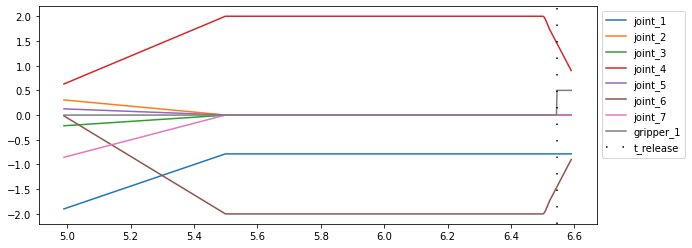

In [6]:
plt.figure(figsize=(10, 4))

viz_times = np.linspace(q_traj.end_time() - 1.6, q_traj.end_time(), 1000)
q_plan = np.hstack([q_traj.value(t) for t in viz_times])
g_plan = np.hstack([g_traj.value(t) for t in viz_times])

for idx, r in enumerate(q_plan):
    plt.plot(viz_times, r, label=f"joint_{idx + 1}")
for idx, r in enumerate(g_plan):
    plt.plot(viz_times, r, label=f"gripper_{idx + 1}")
    
plt.axvline(
    x=gripper_cumulative_times_lst[-2],
    color="black", linestyle=(0, (1, 10)), label="t_release"
);
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

# Run simulation

In [7]:
get_gripper_controller_1 = lambda station_plant: GripperControllerUsingIiwaState(
    plant=station_plant,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    T_world_targetRelease=T_world_releasePose,
    dbg_state_prints=False,
)

# doesn't release for the (-6, 6, -1)
get_gripper_controller_2 = lambda station_plant: GripperControllerUsingIiwaStateV2(
    plant=station_plant,
    gripper_to_object_dist=GRIPPER_TO_OBJECT_DIST,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    p_world_target=T_world_target.translation(),
    height_thresh=0.0, # tunable parameter
    dbg_state_prints=True
)

# do the thing
simulator, station_plant, meshcat, state_logger = BuildAndSimulateTrajectory(
    q_traj=q_traj,
    g_traj=g_traj,
    get_gripper_controller=get_gripper_controller_1,
    T_world_objectInitial=T_world_objectInitial, # where to init the object in the world
    T_world_targetBin=T_world_target, # where the ball should hit - aka where the bin will catch it
    zmq_url=zmq_url,
    time_step=1e-3 # target (-6, 6, -1). 1e-3 => overshoot barely, 1e-4 => undershoot barely, look around 7.92-7.94 s in sim
)

visualize_transform(
    meshcat,
    "TARGET",
    RigidTransform(RotationMatrix.MakeZRotation(0), P_WORLD_TARGET),
    prefix='',
    length=0.3,
    radius=0.02
)

throw_time = 2
meshcat.start_recording()
print(f"Throw motion should happen from 6.5 seconds to {6.5 + time_reqd} seconds")
print(f"Running for {q_traj.end_time() + throw_time} seconds")
simulator.AdvanceTo(q_traj.end_time() + throw_time)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6021...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7021/static/
Connected to meshcat-server.
Throw motion should happen from 6.5 seconds to 6.589846105263907 seconds
Running for 8.589846105263906 seconds
curr: [-0.152  0.15   0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0.313  0.599]
curr: [-0.152  0.151  0.445] target: [-0.313  0

curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.152  0.446] target: [-0

curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0.313  0.313  0.599]
curr: [-0.153  0.153  0.446] target: [-0

### Simulation visualization (+ comparison with plan)

Approx release time: 6.583


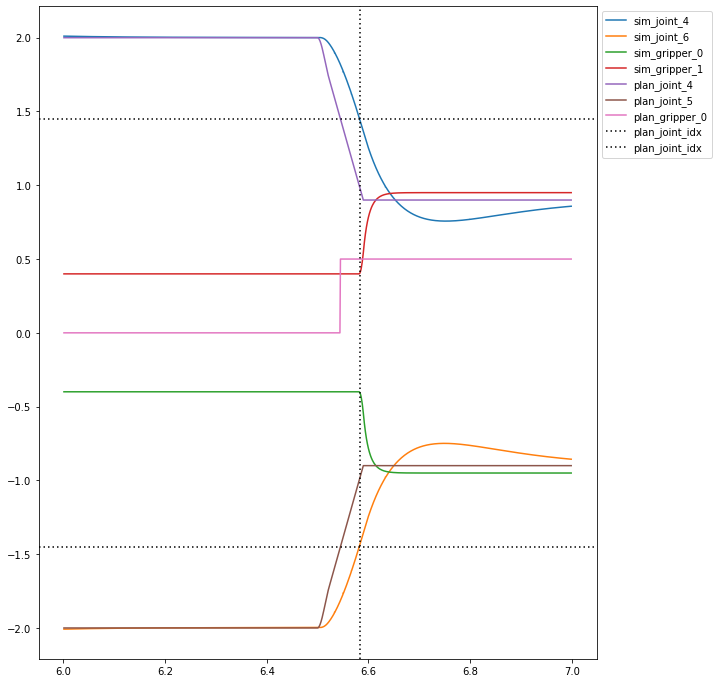

In [8]:
plt.figure(figsize=(10, 12))

all_log_times = state_logger.sample_times()
chosen_idxs = (6 < all_log_times) & (all_log_times < 7)

log_times = state_logger.sample_times()[chosen_idxs]
log_states = state_logger.data()[:, chosen_idxs]

for idx, r in enumerate(log_states[[10, 12]]):
    plt.plot(log_times, r, label=f"sim_joint_{2*idx+4}")
for idx, r in enumerate(log_states[[14, 15]]):
    plt.plot(log_times, 10 *r, label=f"sim_gripper_{idx}")
    
q_plan = np.hstack([q_traj.value(t) for t in log_times])
g_plan = np.hstack([g_traj.value(t) for t in log_times])
for idx, r in enumerate(q_plan[[3, 5]]):
    plt.plot(log_times, r, label=f"plan_joint_{idx + 4}")
for idx, r in enumerate(g_plan):
    plt.plot(log_times, r, label=f"plan_gripper_{idx}")

for idx in [4, 6]:
    plt.axhline(
        y=release_ja[idx-1],
        color="black", linestyle=(0, (1, 2)), label=f"plan_joint_idx"
    );

approx_release_idx = np.where(log_states[15] > log_states[15].min() + 1e-4)[0][0]
approx_release_time = log_times[approx_release_idx]
print(f"Approx release time: {approx_release_time}")
plt.axvline(
    x=approx_release_time,
    color="black", linestyle=(0, (1, 2)), label=""
);

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

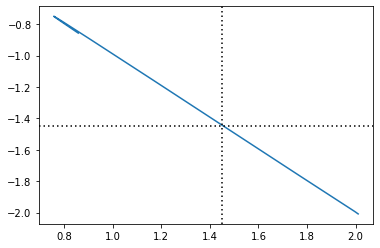

In [9]:
plt.plot(log_states[10], log_states[12]);
plt.axvline(
    x=release_ja[3],
    color="black", linestyle=(0, (1, 2))
);
plt.axhline(
    y=release_ja[5],
    color="black", linestyle=(0, (1, 2))
);

In [10]:
context = simulator.get_context()
station_plant.GetPositions(
    station_plant.GetMyContextFromRoot(context),
    station_plant.GetModelInstanceByName("sphere")
)

array([ -4.762, -16.537,  -4.063,  12.401,  -6.45 ,   8.765,  -5.879])